In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,precision_recall_curve,precision_score,recall_score,
                             f1_score,classification_report,confusion_matrix,roc_curve,roc_auc_score)
from scipy.sparse import hstack,csr_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Initial Analysis

In [2]:
def load_amazon_dataset(file_path):
    """Load Amazon reviews dataset with enhanced validation"""
    print("\n📁 Loading Amazon Reviews Dataset...")
    print("=" * 40)

    df=pd.read_csv(file_path)
    print(f"📊 Initial Dataset Shape: {df.shape}")
    print(f"📋 Avaliable Columns: {list(df.columns)}")

    #validation required columns
    required_cols=['reviews.text','reviews.rating']
    missing_cols=[col for col in required_cols if col not in df.columns]

    if missing_cols:
        raise ValueError(f"❌ Missing required columns: {missing_cols}")

    print(f"✅ Required columns validared: {required_cols}")

    #Display basic statistics
    print(f"\n📊 Dataset Overview:")
    print(f"    Total Reviews: {len(df):,}")
    print(f"    Rating Distribution:")
    for rating in sorted(df['reviews.rating'].dropna().unique()):
        count=(df['reviews.rating']==rating).sum()
        percentage=(count/len(df))*100
        print(f"        {rating} stars: {count:,} ({percentage:.2f}%)")

    return df

# Example usage
df=load_amazon_dataset('/content/245_1.csv')


📁 Loading Amazon Reviews Dataset...
📊 Initial Dataset Shape: (71044, 25)
📋 Avaliable Columns: ['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc']
✅ Required columns validared: ['reviews.text', 'reviews.rating']

📊 Dataset Overview:
    Total Reviews: 71,044
    Rating Distribution:
        1 stars: 3,701 (5.21%)
        2 stars: 1,833 (2.58%)
        3 stars: 4,369 (6.15%)
        4 stars: 14,598 (20.55%)
        5 stars: 46,543 (65.51%)


### Data Cleaning and Validation

In [3]:
def preprocess_dataset(df):
  """Clean and validate dataset"""
  print("\n🧹 Data Preprocessing Pipeline")
  print("-" * 35)

  initial_rows=len(df)
  print(f"📊 Initial rows: {initial_rows:,}")

  #Remove null values and validate
  df = df.dropna(subset=['reviews.text', 'reviews.rating'])
  df['reviews.rating']=pd.to_numeric(df['reviews.rating'],errors='coerce')
  df=df.dropna(subset=['reviews.rating'])
  df=df[df['reviews.rating'].between(1,5)]
  df=df[df['reviews.text'].str.len()>0]
  df=df.reset_index(drop=True)

  final_rows=len(df)
  retention_rate=(final_rows/initial_rows)*100

  print(f"📊 Final preprocessed rows: {final_rows:,}")
  print(f"📈 Data retention Rate: {retention_rate:.2f}%")

  return df

# Execute preprocessing
df_clean = preprocess_dataset(df)


🧹 Data Preprocessing Pipeline
-----------------------------------
📊 Initial rows: 71,044
📊 Final preprocessed rows: 71,008
📈 Data retention Rate: 99.95%


In [4]:
def extract_optimized_features(df):
  """Extract optimized features for faster processing"""
  print("\n⚡ Extracting Optimized Features")
  print("-" * 35)

  # 1. Essential Text Features
  df['review_length'] = df['reviews.text'].str.len()
  df['word_count']=df['reviews.text'].str.split().str.len()
  df['exclamation_count']=df['reviews.text'].str.count('!')
  df['capital_ratio']=df['reviews.text'].apply(lambda x:sum(1 for c in str(x) if c.isupper())/max(len(str(x)),1))

  # 2. Rating features
  df['is_extreme_rating']=((df['reviews.rating']==1) | (df['reviews.rating']==5)).astype(int)

  # 3. Sentiment Analysis (Optimized)
  positive_words=['good','great','excellent','amazing','perfect','love','best','awesome','recommand']
  negative_words=['bad','terrible','awful','worst','hate','horrible','disappointing','poor','waste']

  df['positive_word_count']=df['reviews.text'].str.lower().apply(lambda x:sum(1 for word in positive_words if word in str(x).split()))
  df['negative_word_count']=df['reviews.text'].str.lower().apply(lambda x:sum(1 for word in negative_words if word in str(x).split()))

  # 4. Rating-Text Mismatch Detection
  df['rating_text_mismatch']=(
      ((df['reviews.rating']>=4) & (df['negative_word_count']>df['positive_word_count'])) |
      ((df['reviews.rating']>=2) & (df['positive_word_count']>df['negative_word_count']))
  ).astype(int)

  # 5. User Behavior (if avalible)
  if 'reviews.username' in df.columns:
    user_stats=df.groupby('reviews.username')['reviews.rating'].agg(['count','mean']).round(3)
    user_stats.columns=['user_review_count','user_avg_rating']
    df=df.merge(user_stats,left_on='reviews.username',right_index=True,how='left')
  else:
    df['user_review_count']=1
    df['user_avg_rating']=df['reviews.rating']

  # 6. verification features
  if 'reviews.didPurchase' in df.columns:
    df['is_verified_purchase'] = df['reviews.didPurchase'].fillna(True).astype(int)
  else:
    df['is_verified_purchase'] = 1  # Default to verified if column doesn't exist

  if 'reviews.numHelpful' in df.columns:
    df['helpful_votes'] = pd.to_numeric(df['reviews.numHelpful']).fillna(0)
  else:
    df['helpful_votes'] = 0  # Default to 0 if column doesn't exist

  print(f"✅ Extracted optimized features successfully")
  return df

In [5]:
def create_smart_fake_labels(df):
  """Create realistic fake lable using multiple indicators"""
  print("\n🏷️ Creating Smart Fake Review Labels")
  print("-"*35)

  # Initialize fake score
  fake_score = np.zeros(len(df))

  # Weight-based scoring system
  weights={
      'very_short':3,   # Very short reviews
      'mismatch':4,   # Rating-text mismatch
      'excessive_caps':2,   # Excessive capitalization
      'excessive_excl':2,   # Too many exclamations
      'unverified':2,   # Unverified purchase
      'extreme_rating':1,   # Extreme rating (1 or 5)
      'no_help_votes':1,    # No helpful votes
  }

  # Apply scoring
  fake_score += (df['word_count']<10) * weights['very_short']
  fake_score += df['rating_text_mismatch'] * weights['mismatch']
  fake_score += (df['capital_ratio']>0.3) * weights['excessive_caps']
  fake_score += (df['exclamation_count']>=3) * weights['excessive_excl']
  fake_score += (df['is_verified_purchase']==0) * weights['unverified']
  fake_score += (df['is_extreme_rating']==1) * weights['extreme_rating']
  fake_score += (df['helpful_votes']==0) * weights['no_help_votes']

  # Add some conteolled randomness for realistic distribution
  np.random.seed(42)
  random_boost = np.random.choice([0,1,2],size=len(df), p=[0.7,0.2,0.1])
  fake_score += random_boost

  # Determine threshold for balanced classes
  threshold = np.percentile(fake_score,80) # Top 20% as fake
  df['is_fake']=(fake_score >= threshold).astype(int)

  # Ensure both classes exist
  fake_count=df['is_fake'].sum()
  if fake_count == 0:
    df.loc[fake_score.nlargest(max(1,len(df)//10)).index, 'is_fake'] = 1
    fake_count=df['is_fake'].sum()
  elif fake_count == len(df):
    df.loc[fake_score.nsmallest(int(0.8*len(df))).index, 'is_fake'] = 0
    fake_count=df['is_fake'].sum()

  genuine_count =len(df) - fake_count

  print(f"✅ Lebals Created:")
  print(f"    Genuine: {genuine_count:,} ({genuine_count/len(df)*100:.2f}%)")
  print(f"    Fake: {fake_count:,} ({fake_count/len(df)*100:.1f}%)")

  return df

In [6]:
class OptimizedFakeReviewDetector:
  """Optimized Fake Review Detection System - Fast & Efficient (No SVM)"""

  def __init__(self):
    #Reduced feature size for faster processing
    self.vectorizer = TfidfVectorizer(
        max_features=500, # Reduced from 1000
        stop_words='english',
        ngram_range=(1,2),
        min_df=3, # Increased to filter rare terms
        max_df=0.9
    )
    self.scaler = StandardScaler()
    self.models = {}
    self.model_results = {}
    self.best_model = None
    self.best_model_name = None

    # Essential numerical features only
    self.numerical_features = [
        'review_length', 'word_count', 'exclamation_count', 'capital_ratio',
        'is_extreme_rating', 'positive_word_count', 'negative_word_count',
        'rating_text_mismatch', 'user_review_count', 'user_avg_rating',
        'is_verified_purchase', 'helpful_votes'
    ]

  def get_optimized_models(self):
    """Define optimizer models for faster training (SVM removed)"""
    return{
        'Random Forest': RandomForestClassifier(
            n_estimators=50,  # Reduced from 100
            max_depth=10,   # Reduced from 15
            min_samples_split=5,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'Logistic Regression': LogisticRegression(
            C=1.0,
            max_iter=500,   # Reduced from 1000
            random_state=42,
            class_weight='balanced'
        ),
        'Naive Bayes': MultinomialNB(alpha=1.0),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,  # Reduced from 100
            learning_rate=0.1,
            max_depth=4,    # Reduced from 6
            random_state=42
        )
    }

  def prepare_features(self,df):
    """Prepare optimized features matrix"""
    print("\n🔧 Preparing Optimized Features")
    print("-"*35)

    # Text features (reduced size)
    print("📝 Processing text features...")
    x_text = self.vectorizer.fit_transform(df['reviews.text'].fillna(''))

    # Numerical features (essential only)
    print("📊 Processing numerical features...")
    available_features = [col for col in self.numerical_features if col in df.columns]

    if available_features:
      x_numerical=df[available_features].fillna(0).values
      x_numerical_scaled=self.scaler.fit_transform(x_numerical)
    else:
      # Fallback features
      x_numerical=np.column_stack([
          df['reviews.text'].str.len().fillna(0),
          df['reviews.text'].str.split().str.len().fillna(0),
          df['reviews.rating'].fillna(3)
      ])
      x_numerical_scaled=self.scaler.fit_transform(x_numerical)
      available_features = ['text_length','word_count','rating'] # Corrected fallback feature names

    self.feature_names = available_features

    # Combine features
    x_combined = hstack([x_text, csr_matrix(x_numerical_scaled)])

    print(f"📊 Feature Matrix: {x_combined.shape}")
    print(f"    Text Features: {x_text.shape[1]}")
    print(f"    Numerical Features: {len(available_features)}")

    return x_combined

  def train_all_models_fast(self, x, y, cv_folds=3):  # Reduced CV folds
    """Fast training with optimized models (No SVM)"""
    print("\n🚀 FAST MODEL TRAINING (NO SVM)")
    print("="*35)

    # Verify classes
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"📊 Class Distribution:")
    for cls,count in zip(unique_classes,class_counts):
      print(f"    Class {cls}:{count:,} ({count/len(y)*100:.1f}%)")

    # Stratified split
    x_train,x_test,y_train,y_test=train_test_split(
        x,y,test_size=0.2,stratify=y,random_state=42
    )

    print(f"📊 Training: {x_train.shape[0]:,}, Testing: {x_test.shape[0]:,}")

    # Get optimized models (no SVM)
    all_models = self.get_optimized_models()
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = {}

    for model_name, model in all_models.items():
      print(f"\n⚡ Training {model_name}...")
      start_time = datetime.now()

      try:
        # Handle Naive Bayes (text only)
        if model_name == 'Naive Bayes':
          # Need to get text feature count from vectorizer after fitting
          text_features_count = self.vectorizer.transform(['']).shape[1]
          x_train_model=x_train[:,:text_features_count]
          x_test_model=x_test[:,:text_features_count]
        else:
          x_train_model=x_train
          x_test_model=x_test


        # Quick cross-validation
        # Check if there are enough samples for cross-validation splits
        if x_train_model.shape[0] < cv.get_n_splits(x_train_model, y_train):
            print(f"  ⚠️ Not enough samples for {cv_folds}-fold cross-validation. Skipping CV.")
            cv_scores = np.array([np.nan]) # Assign NaN or handle appropriately
        else:
            cv_scores = cross_val_score(model, x_train_model, y_train, cv=cv, scoring='f1')


        # Train and predict
        model.fit(x_train_model, y_train)
        y_pred = model.predict(x_test_model)
        y_pred_proba = model.predict_proba(x_test_model)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        try:
          roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        except:
          roc_auc = 0.5

        training_time = (datetime.now() - start_time).total_seconds()

        # Store results
        self.models[model_name] = model
        results[model_name]={
            'model' : model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std() if cv_scores.size > 1 else np.nan, # Handle std for single CV score
            'training_time': training_time,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba[:,1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:,0]
        }

        print(f"  ✅ F1: {f1:.3f} | Accuracy: {accuracy:.3f} | Time: {training_time:.3f}s")

      except Exception as e:
        print(f"  ❌ Error training : {str(e)}")
        continue

    # Find best model
    if results:
      best_model_name = max(results, key=lambda x: results[x]['f1_score'])
      self.best_model = results[best_model_name]['model']
      self.best_model_name = best_model_name

      print(f"\n🏆 Best Model: {best_model_name} (F1: {results[best_model_name]['f1_score']:.3f})")

    self.model_results = results
    return results


  def predict_single_review(self, review_text, rating=5):
    """Fast single prediction"""
    if not self.best_model:
      raise ValueError("No trained model available!")

    # Create temporary dataframe
    temp_df = pd.DataFrame({
        'reviews.text': [review_text],
        'reviews.rating': [rating]
    })

    # Add basic features
    temp_df = extract_optimized_features(temp_df)

    # Transform text using already-fitted vectorizer
    x_text = self.vectorizer.transform([review_text])

    # Get numerical features
    available_features = [col for col in self.numerical_features if col in temp_df.columns]
    if available_features:
      x_numerical = temp_df[available_features].fillna(0).values
      x_numerical_scaled = self.scaler.transform(x_numerical)
    else:
      # Fallback features
      x_numerical = np.column_stack([
          len(review_text),
          len(review_text.split()),
          rating
      ])
      x_numerical_scaled = self.scaler.transform(x_numerical)

    # Combine features
    x_combined = hstack([x_text, csr_matrix(x_numerical_scaled)])

    # Handle different models
    if self.best_model_name == 'Naive Bayes':
      text_features_count = x_text.shape[1]
      prediction = self.best_model.predict(x_combined[:, :text_features_count])[0]
      probability = self.best_model.predict_proba(x_combined[:, :text_features_count])[0]
    else:
      prediction = self.best_model.predict(x_combined)[0]
      probability = self.best_model.predict_proba(x_combined)[0]

    return {
        'review_text': review_text[:100] + '...' if len(review_text) > 100 else review_text,
        'rating': rating,
        'prediction': 'Fake' if prediction == 1 else 'Genuine',
        'confidence': max(probability)*100,
        'fake_probability': probability[1]*100 if len(probability) > 1 else probability[0]*100,
        'model_used': self.best_model_name
    }

  def save_models(self, directory='saved_models'):
    """Save all models quickly"""
    os.makedirs(directory, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    saved_files = {}

    # Save best model only for quick deployment
    best_model_file = f"best_model_{timestamp}.pkl"
    with open(os.path.join(directory, best_model_file), 'wb') as f:
      pickle.dump({
          'model': self.best_model,
          'vectorizer': self.vectorizer,
          'scaler': self.scaler,
          'feature_names': self.feature_names
      }, f)
    saved_files['best_model'] = best_model_file

    # Save complete detector
    detector_file = f"detector_{timestamp}.pkl"
    with open(os.path.join(directory, detector_file), 'wb') as f:
      pickle.dump(self, f)
    saved_files['detector'] = detector_file

    print(f"💾 Models saved: {len(saved_files)} files")
    return saved_files

In [7]:
def create_quick_comparison(results):
    """Create quick performance comparison"""
    if not results:
        return None

    print(f"\n📊 QUICK MODEL COMPARISON (NO SVM)")
    print("-" * 35)

    # Create comparison table
    comparison_data = []
    for model_name, result in results.items():
        comparison_data.append({
            'Model': model_name,
            'F1-Score': result['f1_score'],
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'Training Time (s)': result['training_time']
        })

    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('F1-Score', ascending=False)

    print(df_comparison.to_string(index=False, float_format='%.3f'))

    # Quick visualization
    plt.figure(figsize=(12, 8))

    # Performance metrics
    plt.subplot(2, 2, 1)
    metrics = ['F1-Score', 'Accuracy', 'Precision', 'Recall']
    x = range(len(df_comparison))
    width = 0.2

    for i, metric in enumerate(metrics):
        plt.bar([xi + width * i for xi in x], df_comparison[metric],
                width, label=metric, alpha=0.8)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison (No SVM)')
    plt.xticks([xi + width * 1.5 for xi in x], df_comparison['Model'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Training time
    plt.subplot(2, 2, 2)
    plt.bar(df_comparison['Model'], df_comparison['Training Time (s)'], color='lightcoral')
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison (No SVM)')
    plt.xticks(rotation=45)

    # Confusion matrix for best model
    best_model = df_comparison.iloc[0]['Model']
    best_result = results[best_model]

    plt.subplot(2, 2, 3)
    cm = confusion_matrix(best_result['y_test'], best_result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Genuine', 'Fake'], yticklabels=['Genuine', 'Fake'])
    plt.title(f'Confusion Matrix - {best_model}')

    # ROC curves
    plt.subplot(2, 2, 4)
    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(result['y_test'], result['y_pred_proba'])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC: {result['roc_auc']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (No SVM)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_comparison

In [8]:
def execute_optimized_system(file_path):
    """
    MAIN FUNCTION: Execute optimized fake review detection system (No SVM)
    EVEN FASTER without SVM!
    """
    print("\n🚀 EXECUTING OPTIMIZED FAKE REVIEW DETECTION SYSTEM (NO SVM)")
    print("=" * 60)

    try:
        # Stage 1: Load and preprocess data
        print("\n📊 STAGE 1: Data Loading")
        df = load_amazon_dataset(file_path)
        df_clean = preprocess_dataset(df)

        # Stage 2: Feature engineering (optimized)
        print("\n⚙️ STAGE 2: Feature Engineering")
        df_features = extract_optimized_features(df_clean)

        # Stage 3: Smart labeling
        print("\n🏷️ STAGE 3: Smart Labeling")
        df_labeled = create_smart_fake_labels(df_features)

        # Stage 4: Fast model training (no SVM)
        print("\n🤖 STAGE 4: Fast Model Training (No SVM)")
        detector = OptimizedFakeReviewDetector()
        X_features = detector.prepare_features(df_labeled)
        y_labels = df_labeled['is_fake'].values

        print(f"\n📊 Dataset Summary:")
        print(f"   Samples: {len(y_labels):,} | Features: {X_features.shape[1]:,}")
        print(f"   Genuine: {np.sum(y_labels == 0):,} | Fake: {np.sum(y_labels == 1):,}")

        # Train models (much faster without SVM)
        results = detector.train_all_models_fast(X_features, y_labels)

        # Stage 5: Save models
        print("\n💾 STAGE 5: Saving Models")
        saved_files = detector.save_models()

        # Stage 6: Quick visualization
        print("\n📊 STAGE 6: Results Visualization")
        comparison_df = create_quick_comparison(results)

        # Stage 7: Test predictions
        print("\n🔮 STAGE 7: Testing Predictions")
        test_reviews = [
            {"text": "This product is absolutely amazing! Love it so much!", "rating": 5},
            {"text": "Terrible quality, complete waste of money", "rating": 1},
            {"text": "BEST PURCHASE EVER!!!! HIGHLY RECOMMEND!!!!", "rating": 5},
            {"text": "Average product, decent price", "rating": 3}
        ]

        for i, review in enumerate(test_reviews, 1):
            try:
                prediction = detector.predict_single_review(review['text'], review['rating'])
                print(f"   Test {i}: {prediction['prediction']} ({prediction['confidence']:.1f}% confidence)")
            except Exception as e:
                print(f"   Test {i}: Error - {str(e)}")

        # Final summary
        print(f"\n🎯 SYSTEM COMPLETED SUCCESSFULLY (NO SVM)!")
        print("=" * 40)

        best_model = detector.best_model_name
        best_f1 = results[best_model]['f1_score']
        total_time = sum(r['training_time'] for r in results.values())

        print(f"📊 Results:")
        print(f"   Dataset: {len(df_labeled):,} reviews processed")
        print(f"   Models Trained: {len(results)} (Random Forest, Logistic Regression, Naive Bayes, Gradient Boosting)")
        print(f"   Best Model: {best_model}")
        print(f"   Best F1-Score: {best_f1:.3f}")
        print(f"   Total Training Time: {total_time:.1f}s")
        print(f"   Models Saved: {len(saved_files)} files")

        print(f"\n✅ SUCCESS! Ready for production use (SVM-free)!")

        return {
            'detector': detector,
            'results': results,
            'comparison_df': comparison_df,
            'processed_data': df_labeled,
            'saved_files': saved_files,
            'best_model_name': best_model
        }

    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


🚀 EXECUTING OPTIMIZED FAKE REVIEW DETECTION SYSTEM (NO SVM)

📊 STAGE 1: Data Loading

📁 Loading Amazon Reviews Dataset...
📊 Initial Dataset Shape: (71044, 25)
📋 Avaliable Columns: ['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc']
✅ Required columns validared: ['reviews.text', 'reviews.rating']

📊 Dataset Overview:
    Total Reviews: 71,044
    Rating Distribution:
        1 stars: 3,701 (5.21%)
        2 stars: 1,833 (2.58%)
        3 stars: 4,369 (6.15%)
        4 stars: 14,598 (20.55%)
        5 stars: 46,543 (65.51%)

🧹 Data Preprocessing Pipeline
-----------------------------------
📊 Initial rows: 71,044
📊 Final preprocessed rows: 71,0

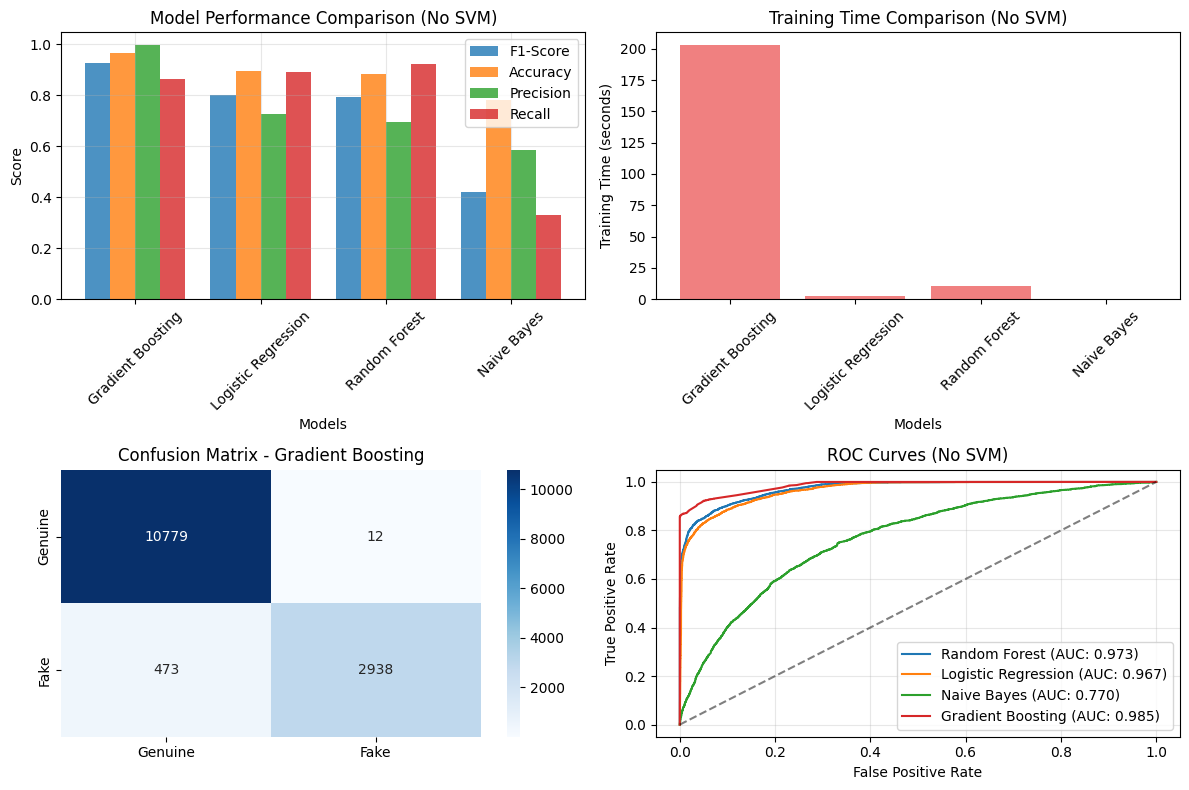


🔮 STAGE 7: Testing Predictions

⚡ Extracting Optimized Features
-----------------------------------
✅ Extracted optimized features successfully
   Test 1: Fake (98.5% confidence)

⚡ Extracting Optimized Features
-----------------------------------
✅ Extracted optimized features successfully
   Test 2: Genuine (99.1% confidence)

⚡ Extracting Optimized Features
-----------------------------------
✅ Extracted optimized features successfully
   Test 3: Fake (99.8% confidence)

⚡ Extracting Optimized Features
-----------------------------------
✅ Extracted optimized features successfully
   Test 4: Genuine (99.3% confidence)

🎯 SYSTEM COMPLETED SUCCESSFULLY (NO SVM)!
📊 Results:
   Dataset: 71,008 reviews processed
   Models Trained: 4 (Random Forest, Logistic Regression, Naive Bayes, Gradient Boosting)
   Best Model: Gradient Boosting
   Best F1-Score: 0.924
   Total Training Time: 216.9s
   Models Saved: 2 files

✅ SUCCESS! Ready for production use (SVM-free)!


In [9]:
results = execute_optimized_system('/content/245_1.csv')